In [1]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import pickle
import gpflow
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
import download_airnow_web
import pyproj
from scipy.optimize import curve_fit
import networkx as nx
from calibration.errormetrics import MAE, MSE, NMSE, NLPD, compute_test_data
from calibration.simple import compute_simple_calibration,compute_simple_predictions, plot_simple_calibration_graph
%matplotlib inline

# Loading data and preparing

Building two simple numpy matrices: X and Y.
X has three columns:
Time (in hours since 15th July, 2020), SensorA, SensorB
Y has two columns, the two measurements.
(I combine the two sensors on the AirQo units).
(Only use data since 15th July).


In [2]:
df = pickle.load(open('alldataprocessed_embassycopy.p','rb'))
encounters = pickle.load(open('encounters_embassycopy.p','rb'))

#this gets rid of unwanted cases where the reference sensors = -1000!
keep=((encounters['pm2_5_sensorA']>=0) & (encounters['pm2_5_sensorB']>=0))
encounters = encounters[keep]
unq = df['channel_id'].unique()


t = (encounters['created_at']-pd.Timestamp('2020-07-15',tz='UTC')).dt.total_seconds()/3600 #hours since 15th July
idA = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorA']]
idB = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorB']]
sA = np.nanmean(encounters[['pm2_5_sensorA','s2_pm2_5_sensorA']],1)
sB = np.nanmean(encounters[['pm2_5_sensorB','s2_pm2_5_sensorB']],1)
X = np.c_[t,idA,idB]
Y = np.c_[sA,sB]

#Here we specify which of the sensors we believe is 'correct'. 
#The last sensor is the embassy. If we just make the embassy
#areference sensor, then we can see how close the calibration
#is to '1' for the other BAM sensor (at the university).

refsensor = np.zeros(len(unq))
refsensor[-1]=1
#refsensor[-2]=1

#This makes it so the smaller id is always first in the pair
swaps = X[:,2]<X[:,1]
X[swaps,1],X[swaps,2] = X[swaps,2],X[swaps,1]
Y[swaps,1],Y[swaps,0] = Y[swaps,0],Y[swaps,1]

#Average blocks of 10 data
newX = []
newY = []
for i in range(0,len(X)-9,10):
    if np.any(X[i:(i+9),1]!=X[(i+1):(i+10),1]): continue
    if np.any(X[i:(i+9),2]!=X[(i+1):(i+10),2]): continue
    newX.append(np.mean(X[i:(i+10),:],0))
    newY.append(np.mean(Y[i:(i+10),:],0))
X = np.array(newX)
Y = np.array(newY)

#Build testX and testY to contain those non-calibration measurements
#that were taken, colocated with our (unmarked) reference sensor (47).
from calibration.errormetrics import compute_test_data
trueY = np.full_like(Y[:,0],np.NaN)
refkeeps = np.isin(X[:,2],[47])
trueY[refkeeps] = Y[refkeeps,1]
refkeeps = np.isin(X[:,1],[47])
trueY[refkeeps] = Y[refkeeps,0]
testX, testY, testtrueY = compute_test_data(X,Y,trueY,refsensor)
#we just keep those that we have a true value for (as they've been colocated with 47)
#AND those that aren't 47 itself (as this we can get 100% accuracy just by reporting
#the same number:
keep = (~np.isnan(testtrueY)[:,0]) & (testX[:,1]!=47) 
testX = testX[keep,:]
testY = testY[keep,:]
testtrueY = testtrueY[keep,:]

In [13]:
unq[refsensor.astype(bool)]

array([-1.])

# Simple Method

In [71]:
delta = 24*7

In [72]:
G,allsp,allcals,allcallists,allpopts,allpcovs,allpoptslists = compute_simple_calibration(X,Y,delta,refsensor)

/home/mike/Documents/Research/calibration/calibration/simple.py:81: RuntimeWarning: invalid value encountered in log
  allpopts[s] = np.sum(np.log([G.get_edge_data(u,v)['popt'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]),0)
/home/mike/Documents/Research/calibration/calibration/simple.py:81: RuntimeWarning: divide by zero encountered in log
  allpopts[s] = np.sum(np.log([G.get_edge_data(u,v)['popt'] for u,v in zip(allsp[s][:-1],allsp[s][1:])]),0)


In [73]:
preds,res2,res = compute_simple_predictions(testX,testY,testtrueY,allcals,delta)

(0.0, 200.0)

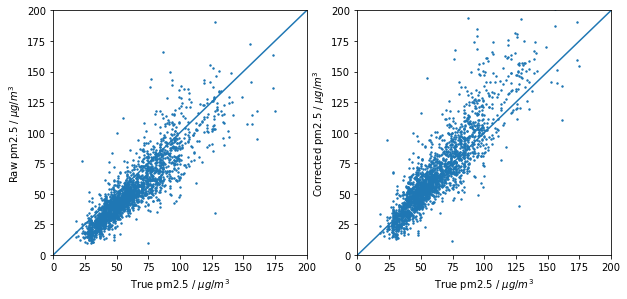

In [7]:
plt.figure(figsize=[10,4.5])
plt.subplot(1,2,1)
plt.ylabel('Raw pm2.5 / $\mu g/m^3$')
plt.xlabel('True pm2.5 / $\mu g/m^3$')
plt.scatter(testtrueY,testY[:,0],2)
plt.plot([0,200],[0,200])
plt.xlim([0,200])
plt.ylim([0,200])
plt.subplot(1,2,2)
plt.ylabel('Corrected pm2.5 / $\mu g/m^3$')
plt.xlabel('True pm2.5 / $\mu g/m^3$')
plt.scatter(testtrueY,preds[:,0],2)
plt.plot([0,200],[0,200])
plt.xlim([0,200])
plt.ylim([0,200])

In [8]:
print("Corrected:")
nmse = NMSE(testtrueY[:,0],preds[:,0])
mse = MSE(testtrueY[:,0],preds[:,0])
mae = MAE(testtrueY[:,0],preds[:,0])
print("nmse=%5.5f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

print("Raw:")
nmse = NMSE(testtrueY[:,0],testY[:,0])
mse = MSE(testtrueY[:,0],testY[:,0])
mae = MAE(testtrueY[:,0],testY[:,0])
print("nmse=%5.5f mse=%5.2f mae=%5.2f" % (nmse,mse,mae))

Corrected:
nmse=0.06521 mse=292.22 mae=10.92
Raw:
nmse=0.06397 mse=286.67 mae=12.72


(500.0, 800.0)

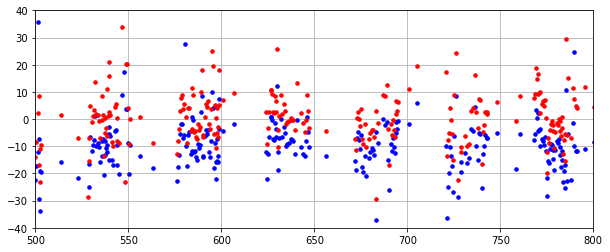

In [9]:
import numpy as np
plt.figure(figsize=[10,4])
keep = ~np.isnan(preds[:,0])
#plt.plot(testX[keep,0],testtrueY[keep,0],'.b',markersize=1)
plt.plot(testX[keep,0],testY[keep,0]-testtrueY[keep,0],'b.',markersize=7)
plt.plot(testX[keep,0],preds[keep,0]-testtrueY[keep,0],'r.',markersize=7)
plt.ylim([-40,40])
plt.grid()
plt.xlim([500,800])

Text(0.5, 0, 'Error / $\\mu g/m^3$')

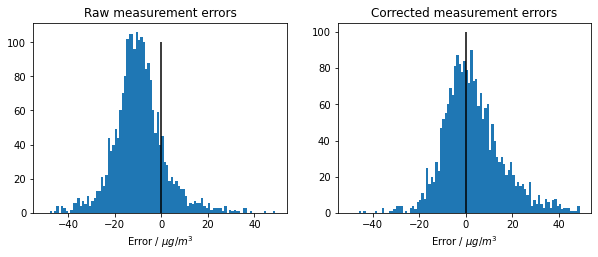

In [10]:
plt.figure(figsize=[10,3.5])
plt.subplot(1,2,1)
plt.hist(testY[:,0]-testtrueY[:,0],np.arange(-50,50));
plt.title('Raw measurement errors')
plt.xlabel('Error / $\mu g/m^3$')
plt.vlines(0,0,100)
plt.subplot(1,2,2)
plt.hist(preds[:,0]-testtrueY[:,0],np.arange(-50,50));
plt.vlines(0,0,100)
plt.title('Corrected measurement errors')
plt.xlabel('Error / $\mu g/m^3$')

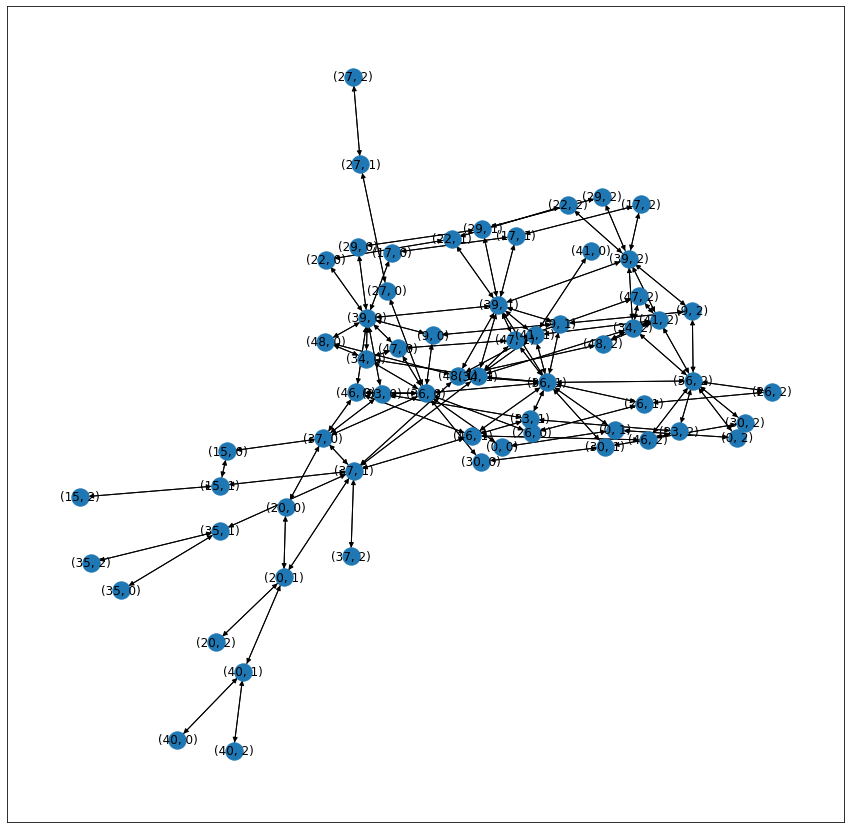

In [11]:
plot_simple_calibration_graph(G)

# Same but using VI method

In [12]:
import numpy as np
from calibration import CalibrationSystem, SparseModel
import gpflow
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
from calibration.errormetrics import MAE, MSE, NMSE, NLPD, compute_test_data
from calibration.synthetic import generate_synthetic_dataset, getstaticsensortranform, getmobilesensortranform

In [13]:
Ttotal = np.max(X[:,0])
Ttotal = 100*int(1+(Ttotal+1)/100)

In [20]:
Z = np.linspace(-200,Ttotal+200,10)[:,None] ##60
def transform_fn(samps,Y,sideY):
    return Y*tf.exp(samps[:,:,0:1])
kernelindices = [[0]*len(unq)]

#this seems to work ok.
k = gpflow.kernels.RBF(5.0,24*40) + gpflow.kernels.Bias(1.5)
cs = CalibrationSystem(X, Y, Z, refsensor, 1, transform_fn, [k], kernelindices,lr=0.01,likelihoodstd=10.0,minibatchsize=50)
import time
before = time.time()
print("Starting Run")
elbo_record = cs.run(2000,samples=200) ##3000 iterations, 300 samples
print(time.time()-before)

Starting Run
Starting Run
....................20 (ELBO=1527641.7500)
....................40 (ELBO=1220181.5000)
..........29.262254238128662


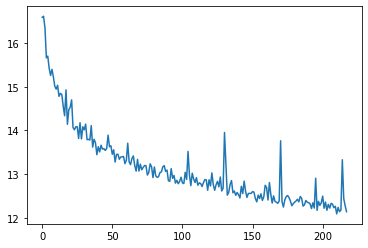

In [19]:
plt.plot(np.log(elbo_record))

<ipython-input-16-51639ba1c8fe>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[14,7])
<ipython-input-16-51639ba1c8fe>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[14,7])
<ipython-input-16-51639ba1c8fe>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[14,7]

<ipython-input-16-51639ba1c8fe>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[14,7])
<ipython-input-16-51639ba1c8fe>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[14,7])
<ipython-input-16-51639ba1c8fe>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[14,7]

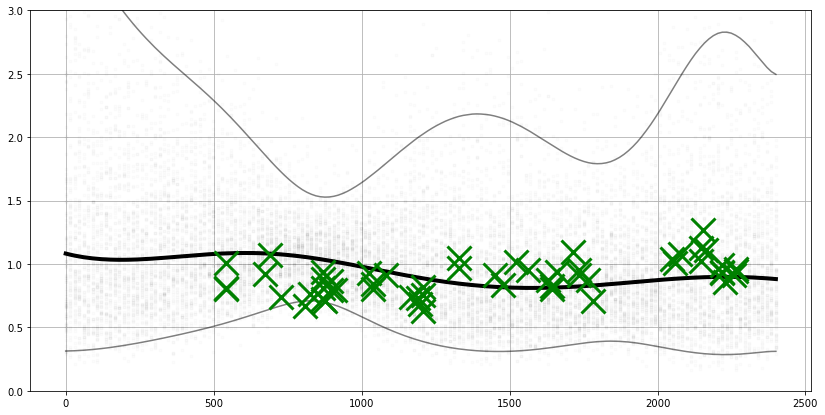

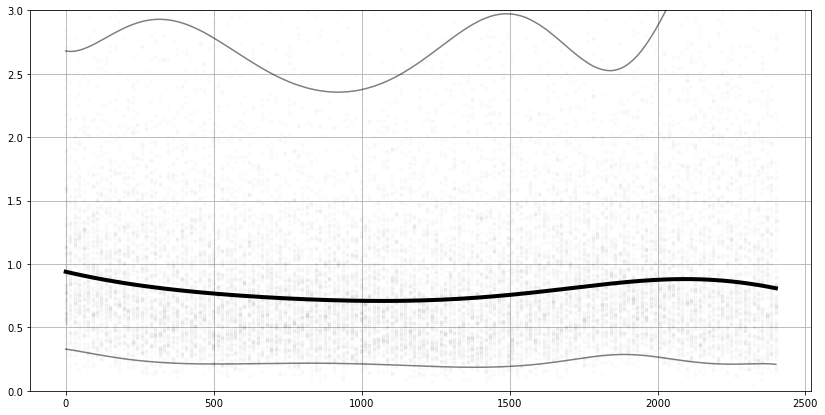

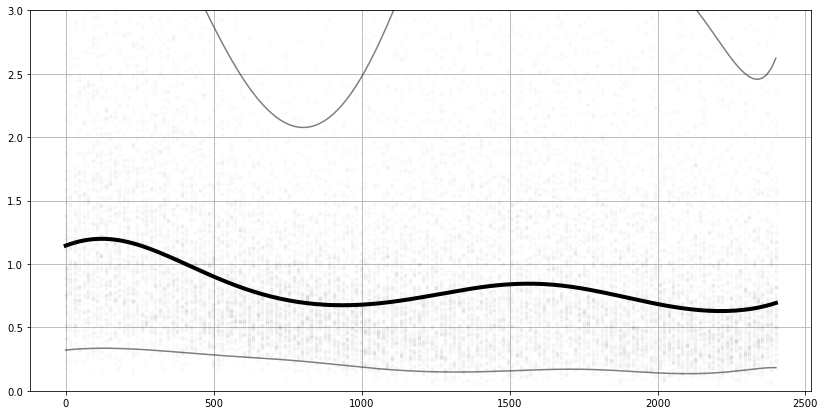

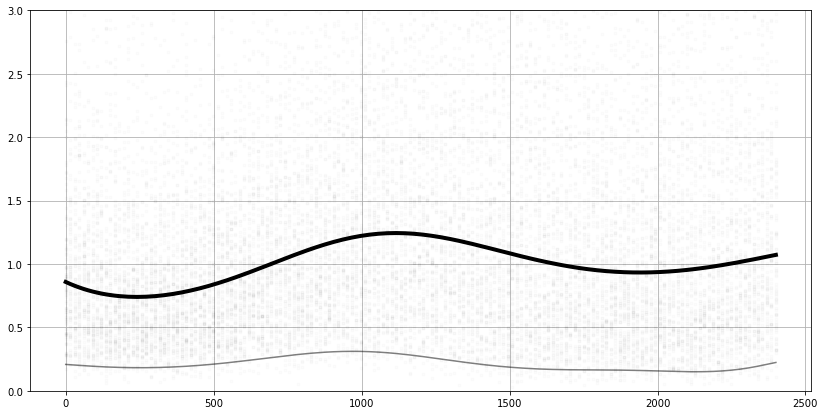

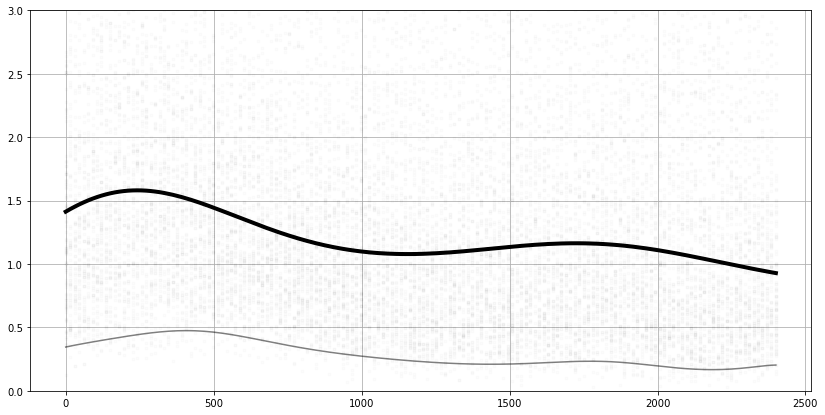

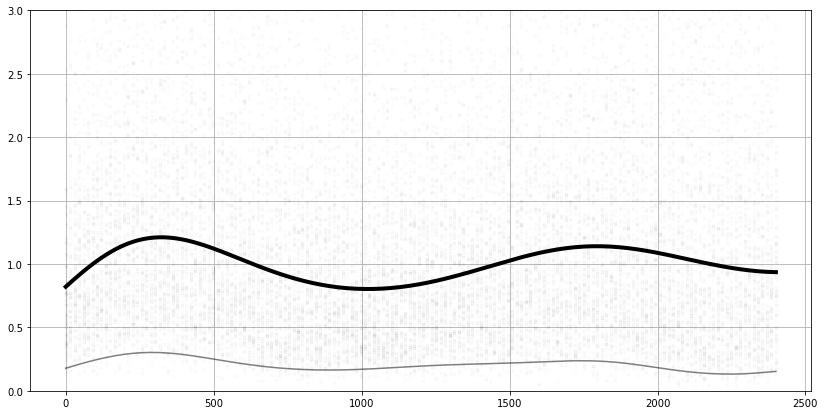

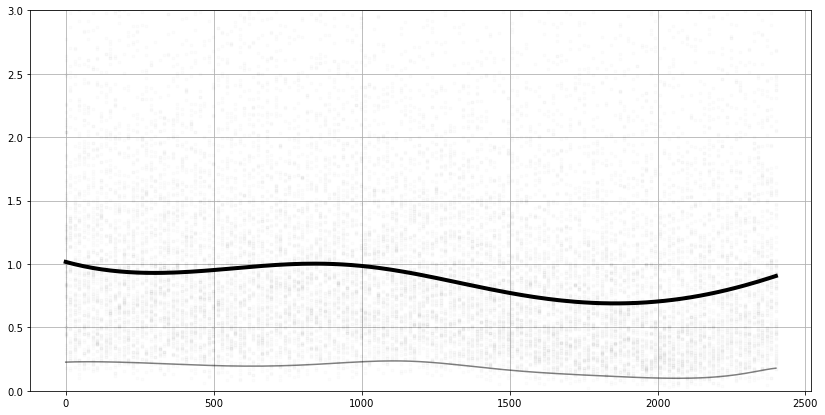

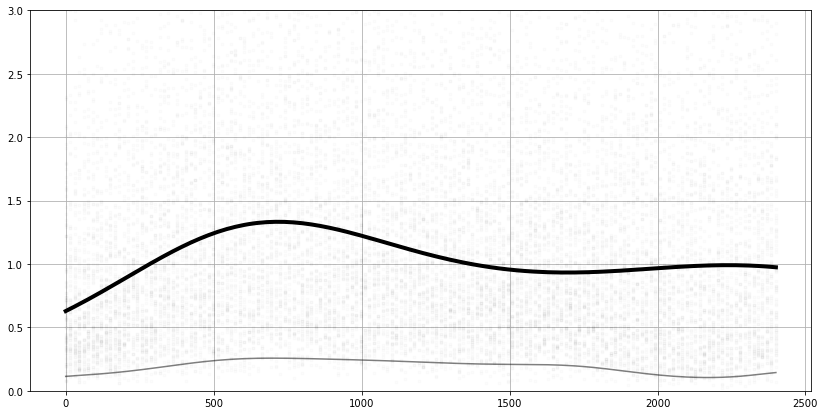

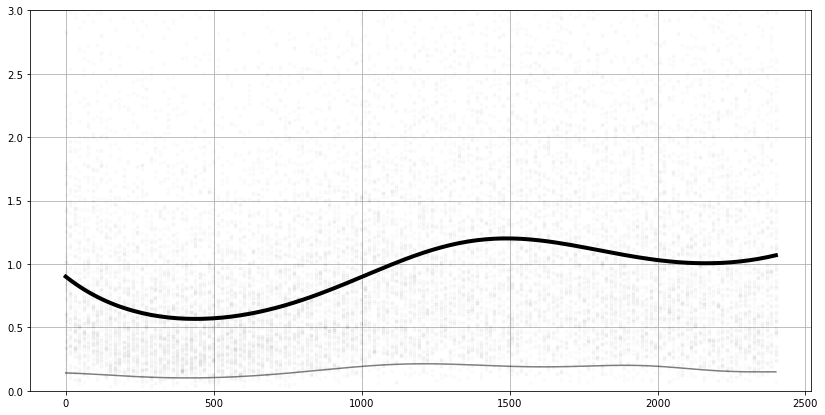

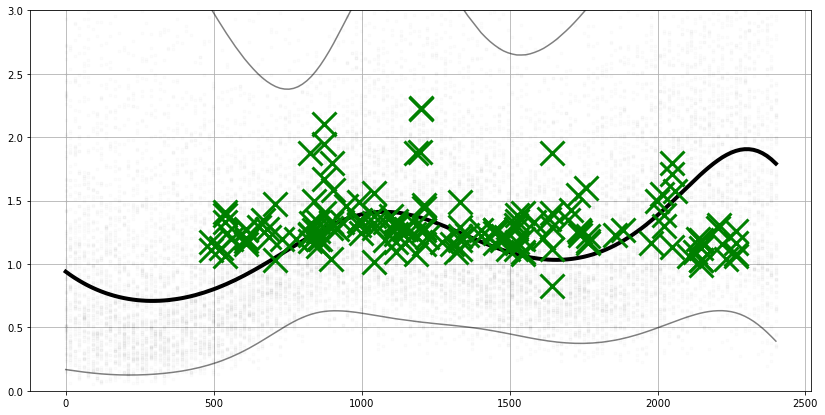

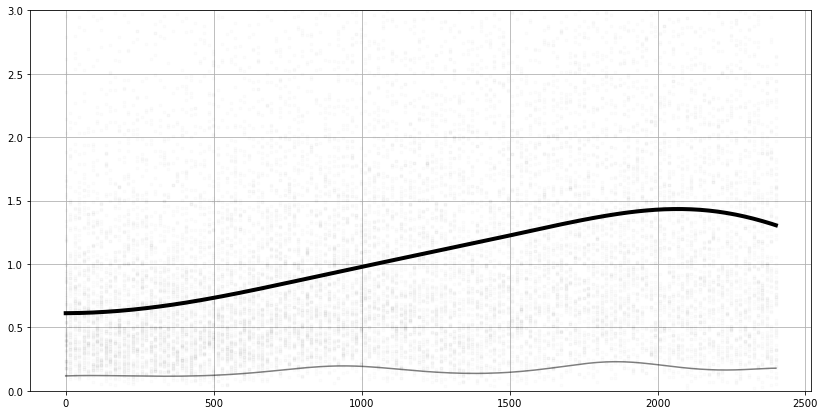

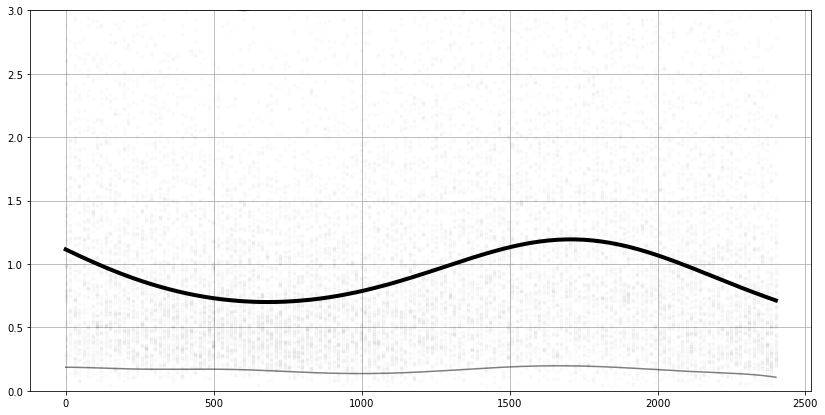

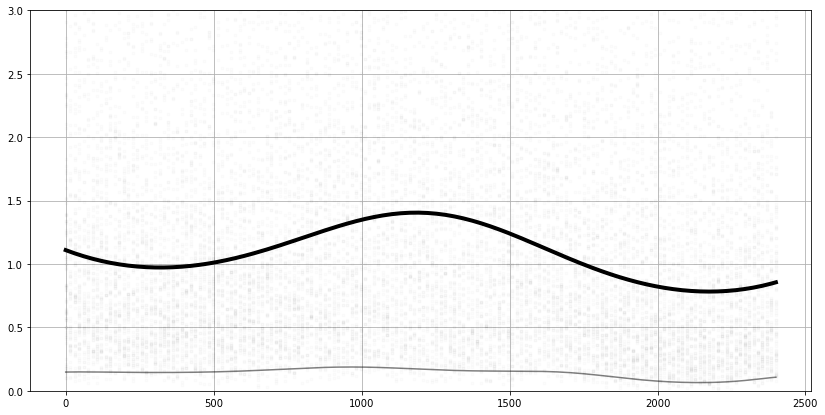

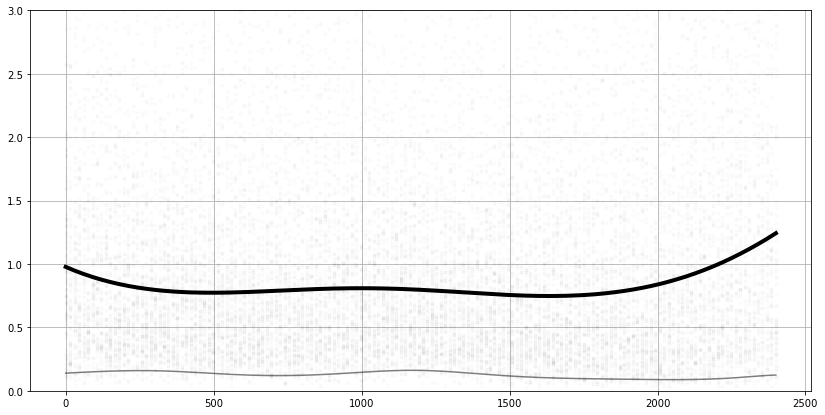

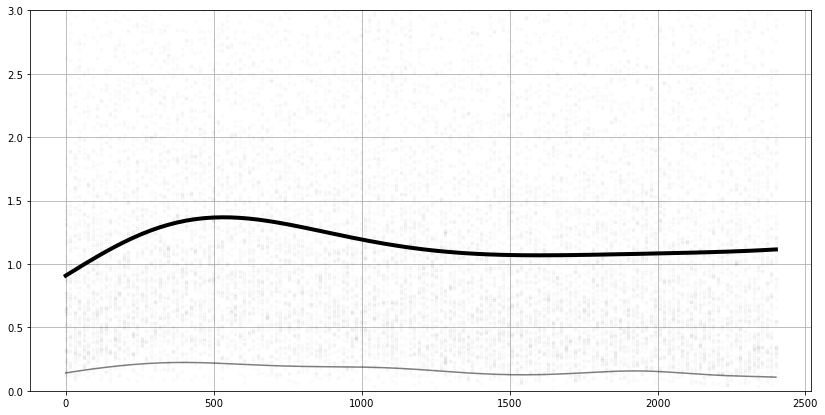

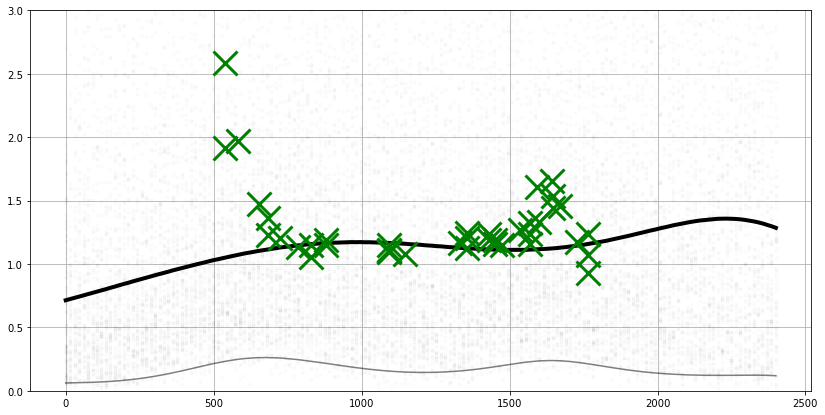

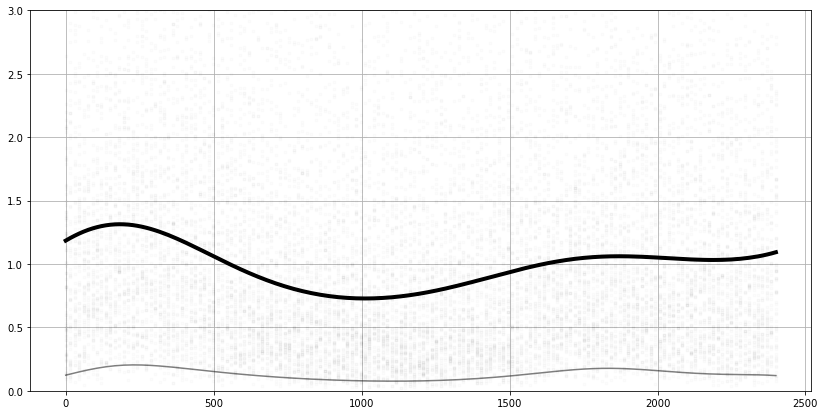

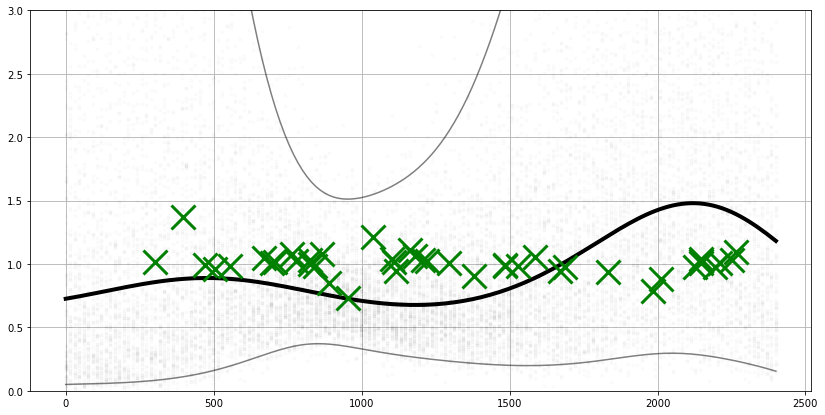

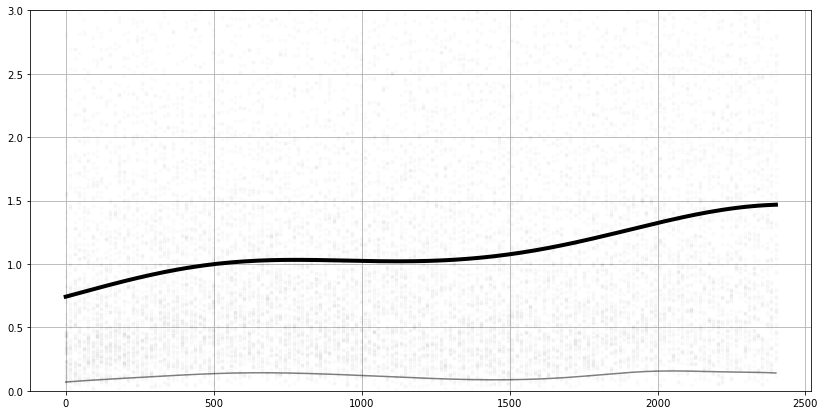

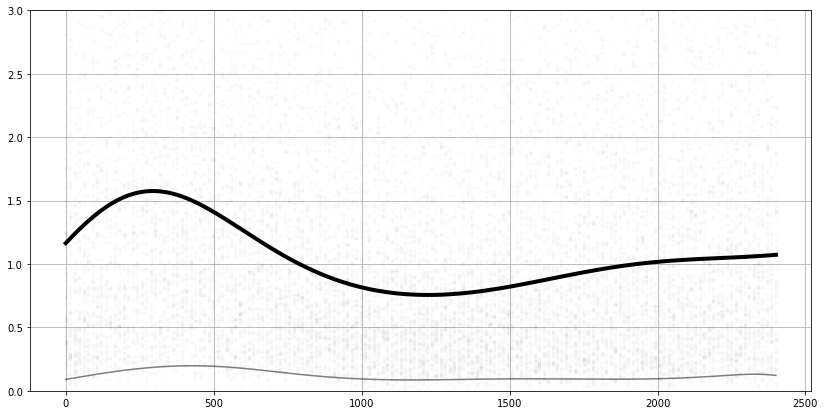

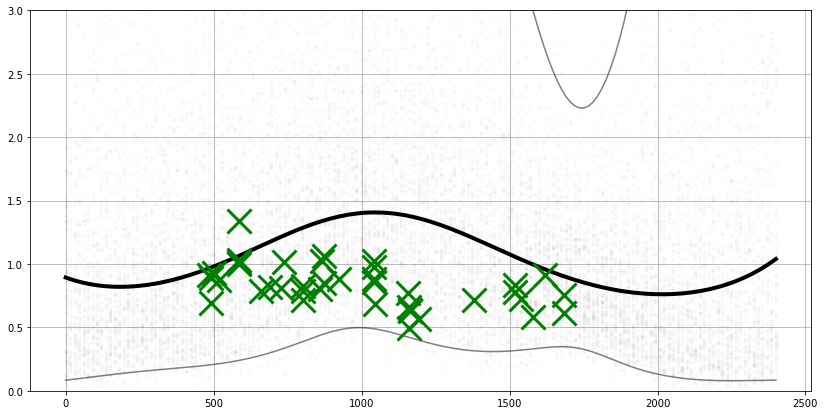

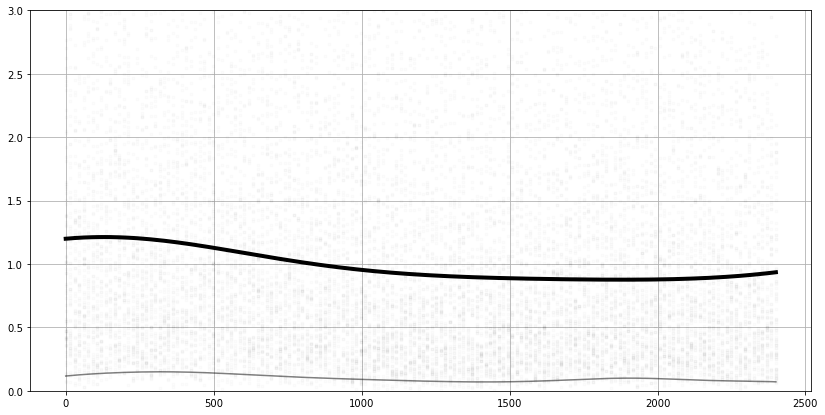

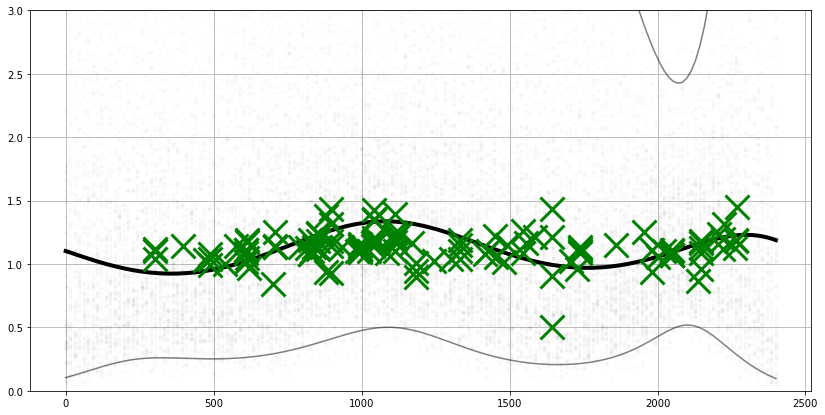

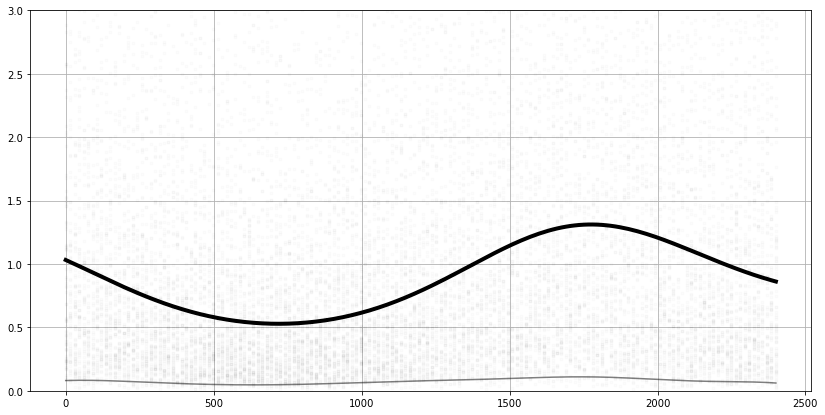

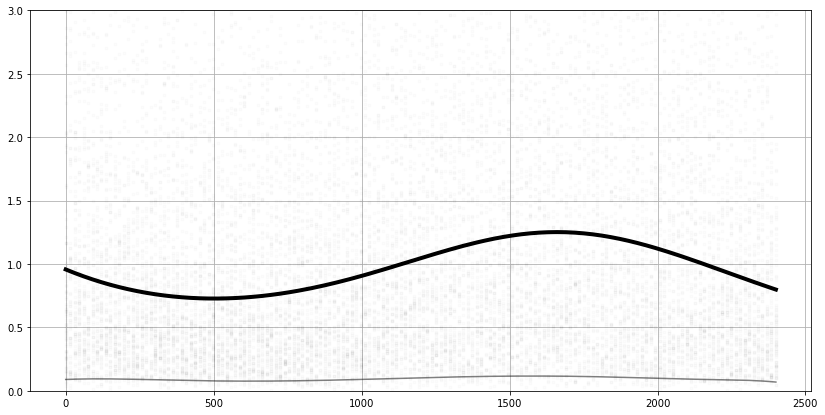

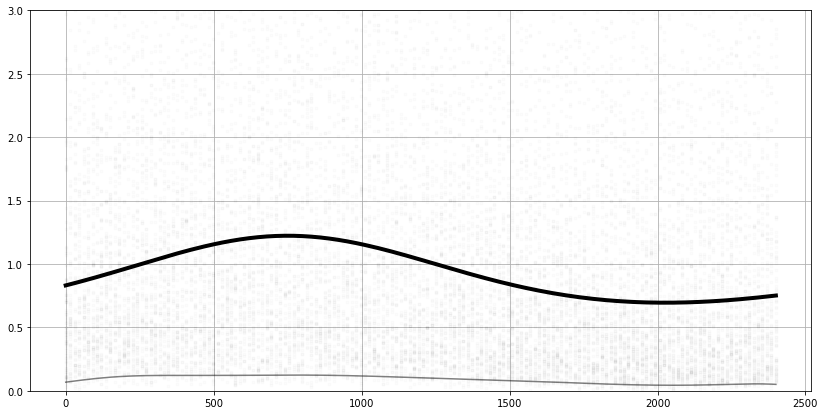

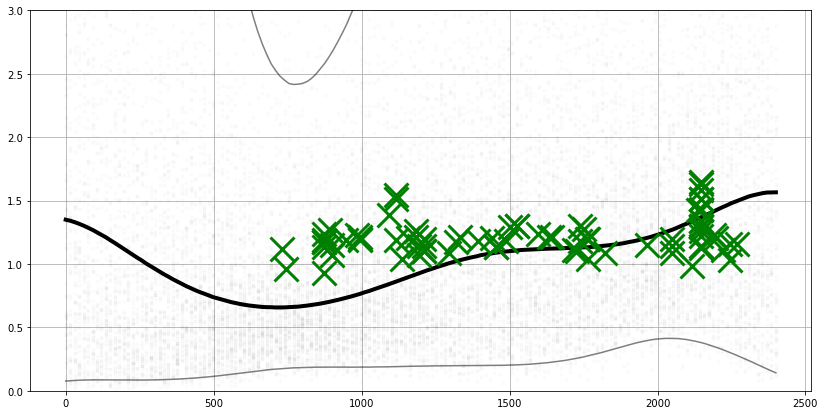

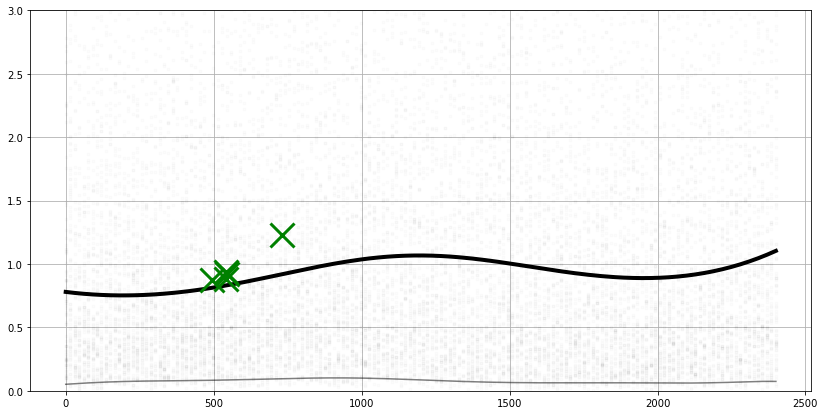

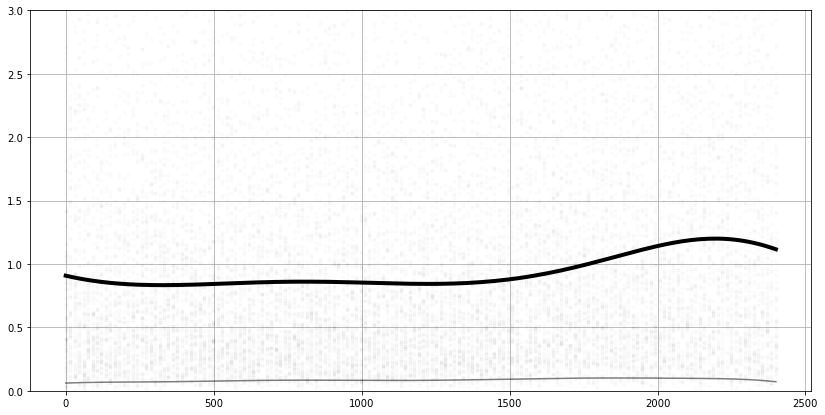

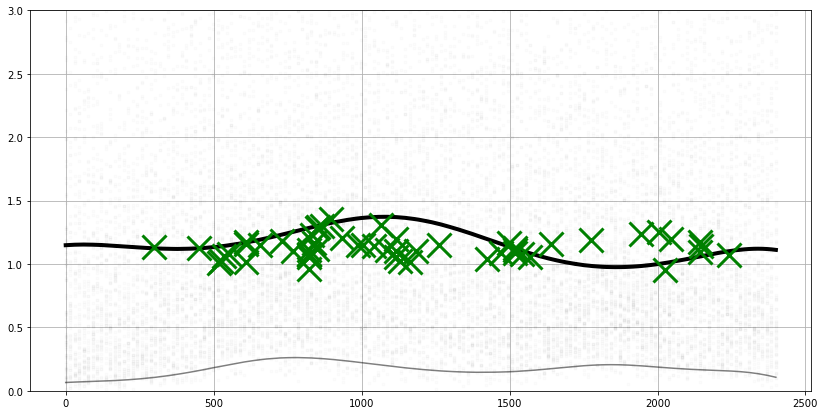

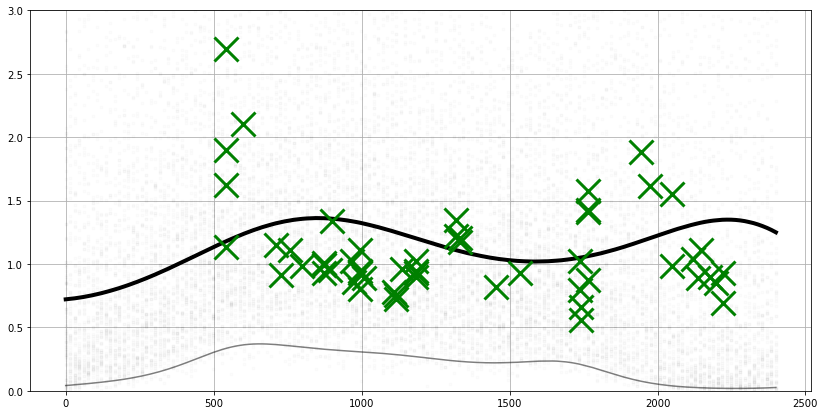

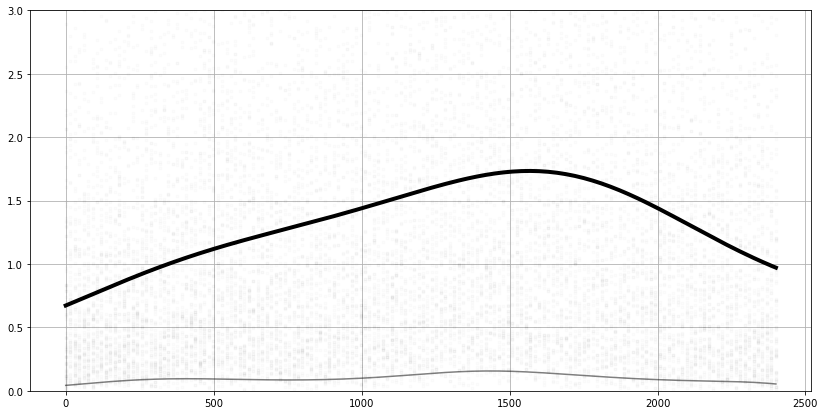

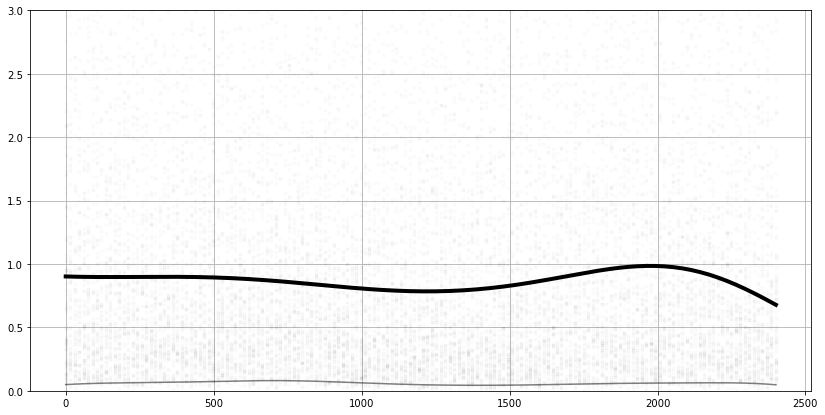

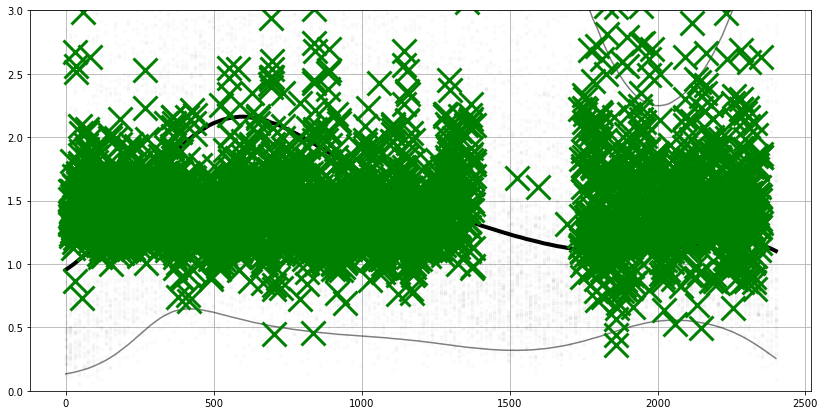

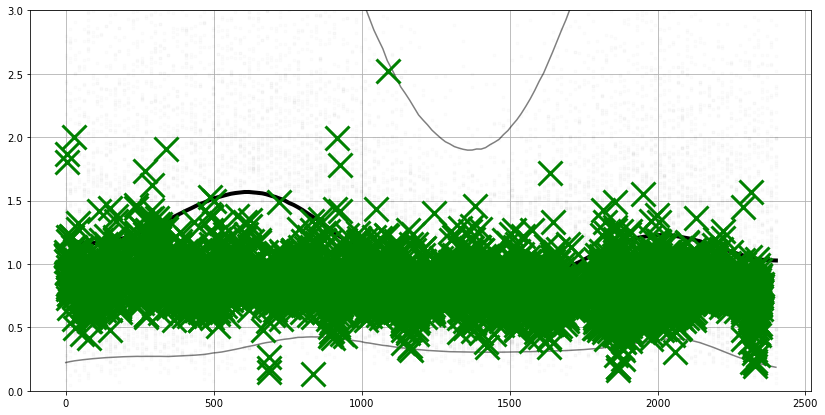

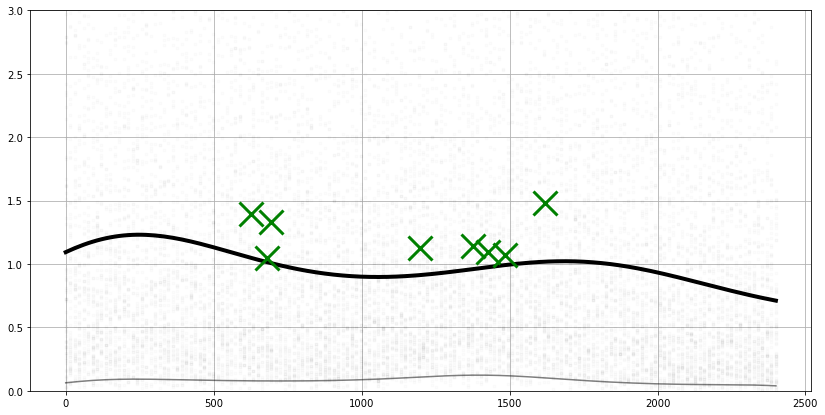

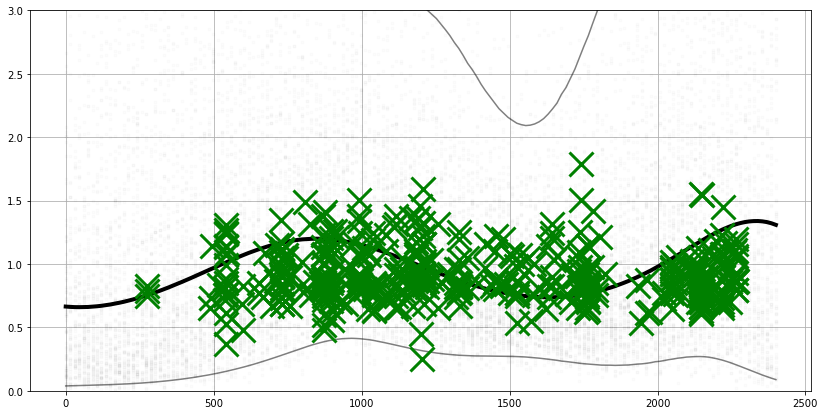

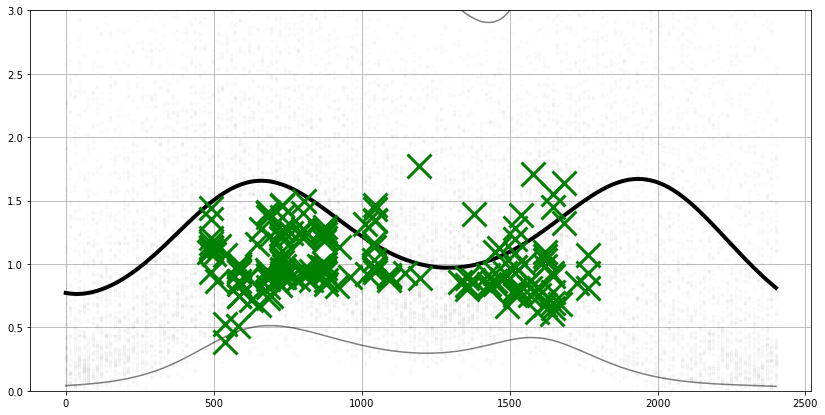

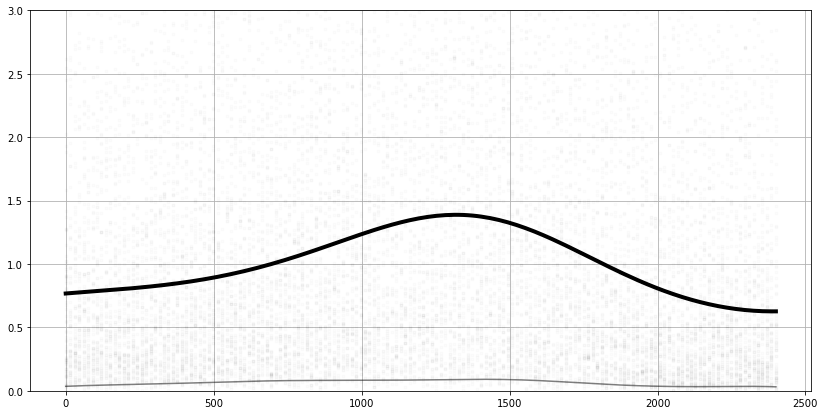

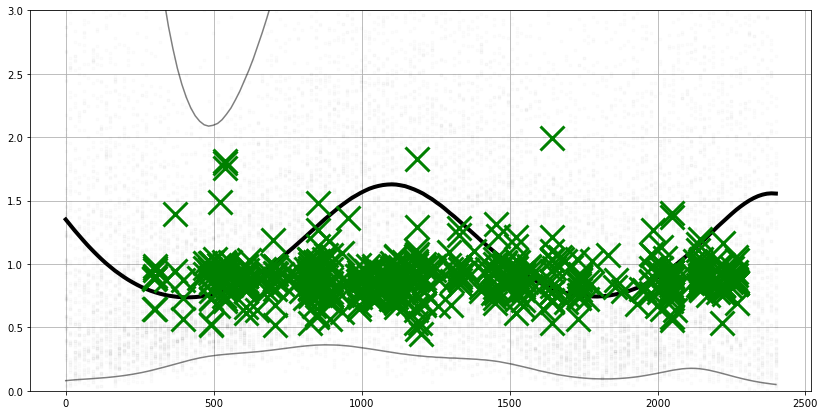

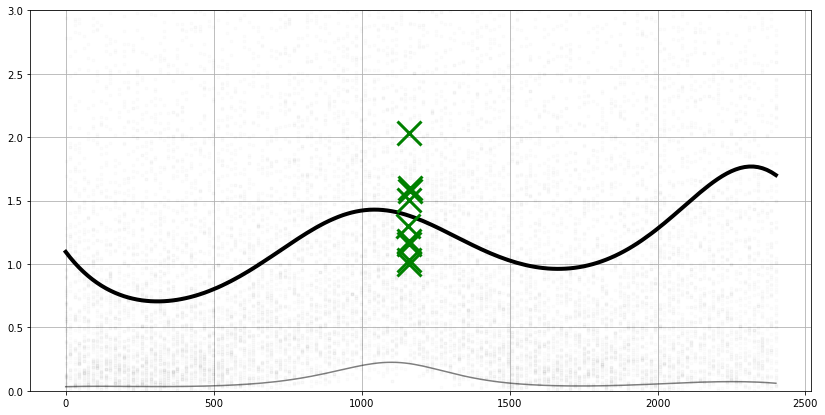

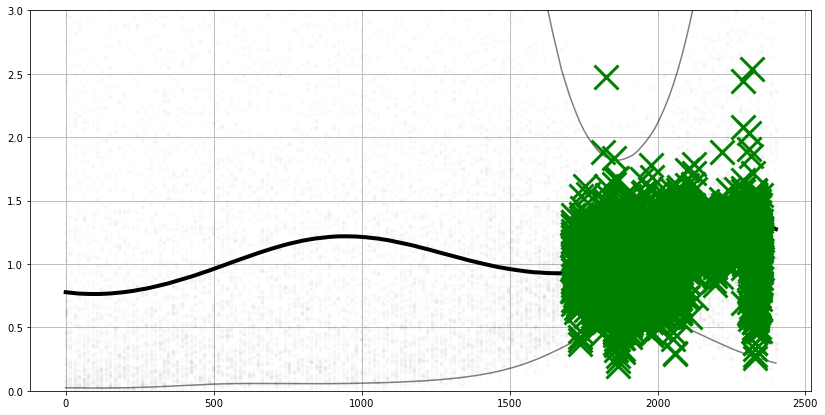

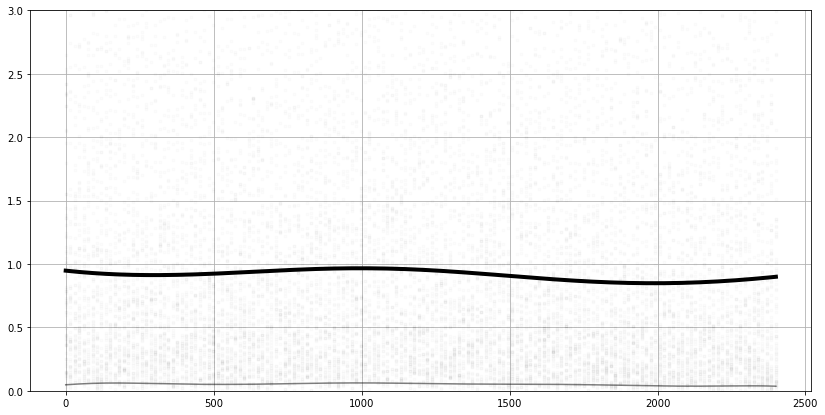

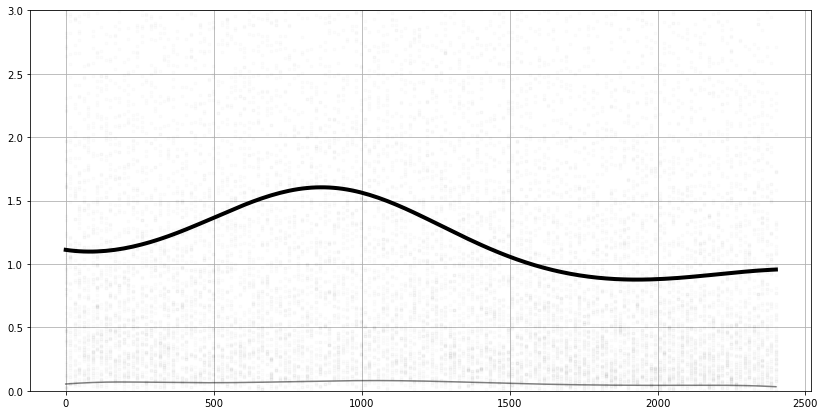

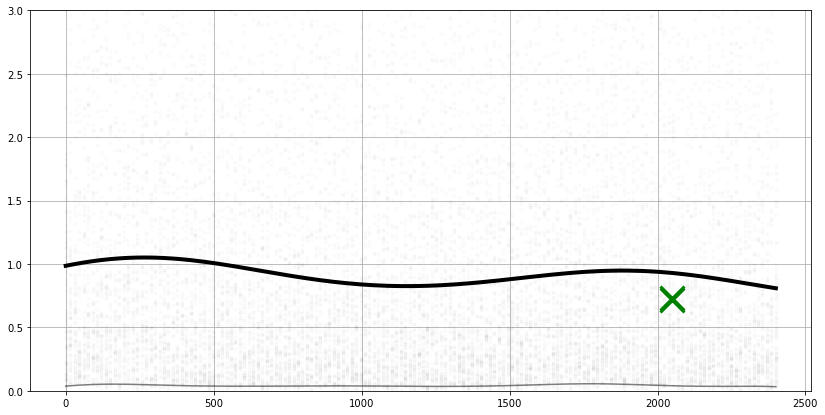

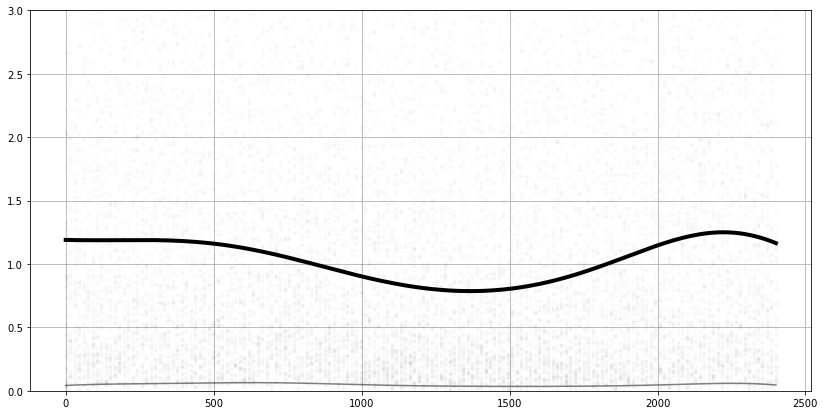

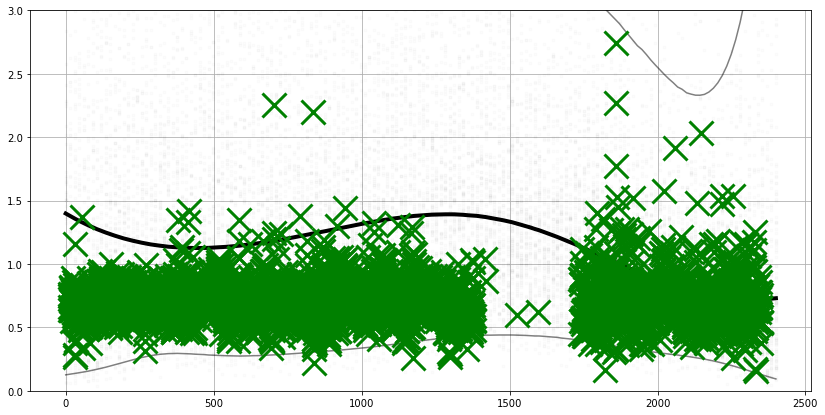

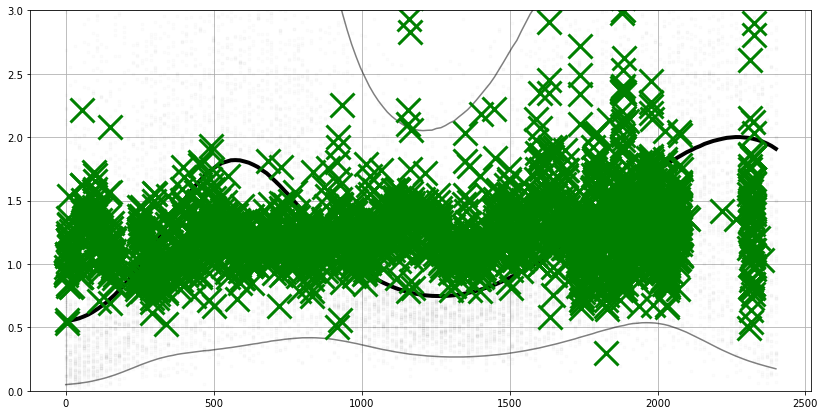

In [16]:
C = 1
for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(0,Ttotal,160)
    plottestX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        plottestX = np.r_[plottestX,tempX]#.astype(int)
    testsm = SparseModel(plottestX,cs.Z,C,cs.k)
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    if cs.mulike is not None:
        qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
        sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    plt.figure(figsize=[14,7])
    plt.plot(x,1/tf.exp(qf_mu[:,0]),'k-',lw=4)
    plt.plot(x,1/np.exp(samps[:,:,0].numpy().T),'k.',alpha=0.01);
    
    plt.plot(x,1/tf.exp((qf_mu[:,0]+2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)
    plt.plot(x,1/tf.exp((qf_mu[:,0]-2*np.sqrt(np.diag(qf_cov)[:]))),'k-',alpha=0.5)

    senseX = (X[:,1]==si)# & (X[:,2]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'xg',markersize=24,mew=3) 
    senseX = (X[:,2]==si)# & (X[:,1]<Nrefs)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'xg',markersize=24,mew=3)
    senseX = (X[:,1]==si)
    plt.plot(X[senseX,0],Y[senseX,0]/Y[senseX,1],'.g',markersize=7)
    senseX = (X[:,2]==si)
    plt.plot(X[senseX,0],Y[senseX,1]/Y[senseX,0],'.g',markersize=7)    
    #plotbars(np.arange(0,np.max(X[:,0]),delta),delta,np.exp(allscales[:,si]),'y')
    plt.ylim([0,3])
    plt.grid()

In [17]:
testsm = SparseModel(testX,cs.Z,1,cs.k)
qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)

In [18]:
predY = transform_fn(qf_mu[None,:,:],testY[:,0:1],None).numpy()[:,:,0].T
#predY[predY>100]=100

nlpd = NLPD(np.log(testtrueY[:,0]),np.log(testY[:,0:1])+qf_mu[:,0],np.sqrt(np.diag(qf_cov)))
keep = ~np.isnan(testtrueY)
nmse = NMSE(testtrueY[:,0],predY[:,0])
mse = MSE(testtrueY[:,0],predY[:,0])
mae = MAE(testtrueY[:,0],predY[:,0])
print("nlpd=%5.2f nmse=%5.5f mse=%5.2f mae=%5.2f" % (nlpd,nmse,mse,mae))

nlpd= 1.27 nmse=0.10970 mse=491.62 mae=17.49
